In [1]:
# pip install --upgrade xarray seaborn pandas numpy

In [4]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns

1. Extracting XArray data into Tidy Pandas DataFrames
  - Multiple columns
2. Plotting Subsets of your data using Logical Indexing
  - `sns.relplot(data=, x=, y=, estimator=, errorbar=, col=, col_wrap=, kind='line')`
3. Making and Displaying Pivot Tables (`df.groupby().agg().unstack()`), (`df.pivot_table(index='col1', columns='col2', values='col3', agg='mean')`
  - `sns.heatmap`
    - 'annot=' and 'fmt=
    - normalize along different axes?
  - `style.background_gradient()`

In [26]:
pd.crosstab(index=df.time, columns=df.brain_area, values=df.lfp)
df.pivot_table(index='time', columns='brain_area', values='lfp')

col_0,1,2,3
row_0,,,
1,11.111111,11.111111,11.111111
2,11.111111,11.111111,11.111111
3,11.111111,11.111111,11.111111


In [10]:
pd.crosstab?

Signature:
pd.crosstab(
    index,
    columns,
    values=None,
    rownames=None,
    colnames=None,
    aggfunc=None,
    margins: 'bool' = False,
    margins_name: 'Hashable' = 'All',
    dropna: 'bool' = True,
    normalize: 'bool' = False,
) -> 'DataFrame'
Docstring:
Compute a simple cross tabulation of two (or more) factors.

By default, computes a frequency table of the factors unless an
array of values and an aggregation function are passed.

Parameters
----------
index : array-like, Series, or list of arrays/Series
    Values to group by in the rows.
columns : array-like, Series, or list of arrays/Series
    Values to group by in the columns.
values : array-like, optional
    Array of values to aggregate according to the factors.
    Requires `aggfunc` be specified.
rownames : sequence, default None
    If passed, must match number of row arrays passed.
colnames : sequence, default None
    If passed, must match number of column arrays passed.
aggfunc : function, optional
   

### Download the dataset

In [3]:
from pathlib import Path
import requests
from tqdm import tqdm

def download_from_sciebo(public_url, to_filename, is_file=True):
    """
    Downloads a file or folder from a shared URL on Sciebo.
    """
    # Create the folder if a longer path was described
    path = Path(to_filename)
    if len(path.parts) > 1:
        Path(to_filename).parent.mkdir(parents=True, exist_ok=True)

    r = requests.get(public_url + "/download", stream=True)

    if 'Content-Length' in r.headers and is_file:
        total_size = int(r.headers['Content-Length'])
        progress_bar = tqdm(desc=f"Downloading {to_filename}", unit='B', unit_scale=True, total=total_size)
    else:
        progress_bar = None

    with open(to_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
            if progress_bar:
                progress_bar.update(len(chunk))

    if progress_bar:
        progress_bar.close()

download_from_sciebo('https://uni-bonn.sciebo.de/s/JFeueaaWCTVhTZh', 'data/steinmetz_2016-12-14_Cori.nc')

# ERP Analysis With Pandas And Seaborn

---

## Overview

We will continue to use [Steinmetz et al, 2019 in Nature](https://www.nature.com/articles/s41586-019-1787-x) dataset. The experiment involved a mouse being presented with two gradients of varying intensities. The mouse's task was to adjust a wheel to center the brighter gradient on the screen. Simultaneously, Local Field Potential (LFP) measurements were recorded across various brain areas. These measurements were taken 250 times in 2.5 seconds, with data collected at 0.01-second intervals. 


**Analysis goals**

In these exercises, our primary objective is to analyze and visualize Local Field Potential (LFP) data collected from distinct brain regions separately. Through this analysis, we aim to:
  - compute trial statistics on LFP amplitudes (e.g. mean, min, max)
  - compare these statistics between different brain areas
  

**Learning goals**

In this notebook, we'll focus on learning Seaborn's:
  - `sns.lineplot()` function for plotting time series models
  - `sns.relplot()` for making faceted rows and columns of data of figures effectively using relplot and
  - `sns.heatmap()` for using colors to compare trends.

---
## Extracting Data from XArray Datasets into Tidy DataFrames
### Load Dataset

In this section, we'll work with a dataset from a single session recording of Cori the mouse ('steinmetz_2016-12-14_Cori.nc'). 

Our primary objective is to read this data and convert it into a Pandas dataframe, which will serve as the foundation for the subsequent exercises.

**Load dataset and convert to Pandas dataframe:**

| Method/Code                                             | Description                                                                   |
|--------------------------------------------------------|-------------------------------------------------------------------------------|
| `dset = xr.load_dataset("path/to/file/like/this.nc")` | Loads the dataset from the specified file path using xarray (`xr`).      |
| `df = dset['column1'].to_dataframe()`                    | Extracts the 'column1' data variable from the dataset and converts it into a Pandas DataFrame (`df`). |
| `df.reset_index()`                                   | Resets the index of the 'df' DataFrame to create a default integer index.   |
| `dset['column1'].to_dataframe().reset_index()` | All of it, together! |

**Exercises**

Make a variable called `dset` by calling by Xarray's `xr.load_dataset()` function on the 'steinmetz_2016-12-14_Cori.nc' session file.  Confirm that the "lfp" data variable is there.

In [6]:
dset = xr.load_dataset('data/steinmetz_2016-12-14_Cori.nc')
dset

<xarray.Dataset>
Dimensions:             (trial: 364, time: 250, cell: 734,
                         waveform_component: 3, sample: 82, probe: 384,
                         brain_area_lfp: 7, spike_id: 2446173)
Coordinates:
  * trial               (trial) int32 1 2 3 4 5 6 7 ... 359 360 361 362 363 364
  * time                (time) float64 0.01 0.02 0.03 0.04 ... 2.48 2.49 2.5
  * cell                (cell) int32 1 2 3 4 5 6 7 ... 729 730 731 732 733 734
  * waveform_component  (waveform_component) int32 1 2 3
  * probe               (probe) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384
  * brain_area_lfp      (brain_area_lfp) object 'ACA' 'LS' ... 'SUB' 'VISp'
  * spike_id            (spike_id) int32 1 2 3 4 ... 2446171 2446172 2446173
Dimensions without coordinates: sample
Data variables: (12/31)
    contrast_left       (trial) int8 100 0 100 0 50 0 0 ... 0 100 50 50 0 25 100
    contrast_right      (trial) int8 0 50 50 0 100 0 0 ... 25 100 25 25 50 0 100
    gocue               (trial) float64 1.027 0.8744 0.8252 ... nan nan nan
    stim_onset          (trial) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feedback_type       (trial) float64 1.0 1.0 1.0 1.0 -1.0 ... nan nan nan nan
    feedback_time       (trial) float64 1.187 1.438 0.986 2.296 ... nan nan nan
    ...                  ...
    waveform_w          (cell, sample, waveform_component) float32 0.0 ... -0...
    waveform_u          (cell, waveform_component, probe) float32 0.0 ... 0.0
    lfp                 (brain_area_lfp, trial, time) float64 -2.851 ... 5.571
    spike_time          (spike_id) float32 0.2676 2.308 0.8535 ... 2.189 2.399
    spike_cell          (spike_id) uint32 1 1 1 1 1 1 ... 734 734 734 734 734
    spike_trial         (spike_id) uint32 21 21 31 37 43 ... 364 364 364 364 364
Attributes:
    session_date:  2016-12-14
    mouse:         Cori
    stim_onset:    0.5
    bin_size:      0.01

**Example** Extract 'brain_area' data variable to Pandas dataframe and store it in ba variable

In [5]:
ba = dset['brain_area'].to_dataframe()
ba

,brain_area
cell,
1,ACA
2,MOs
3,ACA
4,LS
5,MOs
...,...
730,SUB
731,DG
732,DG


Hmm! It might be good to have a separate index instead of using cell as index

**Example** reset_index of ba and display first five rows of the data

In [6]:
ba = ba.reset_index()
ba.head(5)

,cell,brain_area
0,1,ACA
1,2,MOs
2,3,ACA
3,4,LS
4,5,MOs


You can actually do the above two steps into a single step using `dset['brain_area].to_dataframe().reset_index()`. Can you try that out below?

In [7]:
ba = dset['brain_area'].to_dataframe().reset_index()
ba.head(5)

,cell,brain_area
0,1,ACA
1,2,MOs
2,3,ACA
3,4,LS
4,5,MOs


Great! Now, let's do this to the data we are going to use for the exercises

Convert 'lfp' data to Pandas dataframe and store it in lfp variable

In [8]:
lfp = dset['lfp'].to_dataframe().reset_index()
lfp.head(5)

,brain_area_lfp,trial,time,lfp
0,ACA,1,0.01,-2.850794
1,ACA,1,0.02,-4.039683
2,ACA,1,0.03,-4.195238
3,ACA,1,0.04,-3.228571
4,ACA,1,0.05,0.460317


## Explore and Visualize LFP Data for VISp Area

### Selecting Data based on its Values ("Logical Indexing" or "Masking") and Plotting it in MultiFaceted Line Plots with `sns.relplot()`

##### Selecting Data based on its Values ("Logical Indexing" or "Masking") and Plotting it in MultiFaceted Line Plots with `sns.relplot()`

| Code                       | Description                                                         |
|----------------------------------------|---------------------------------------------------------------------|
| `mask = df["col_1"] == 'val_1'`     | Store which values of `col_1` are equal to `'val_'` |
| `mask = mask1 & mask2` | Store which values are true for both `mask1` and `mask2` |
| `mask = mask1 \| mask2` | Store which values are true for at least one of `mask1` or `mask2` |
| `df[mask]` | Get only the rows of `df` for which the values in `mask` are `True`.  |


##### Plotting MultiFaceted Line Plots with Seaborn: `sns.relplot()`

| Code       | Description                                                         |
|-------------------|---------------------------------------------------------------------|
| `sns.relplot()` | Creates a relational plot using Seaborn. Specifies the following parameters:
| | `data`: DataFrame variable that the plot will be made from.
| | `x=`: Column to use for the x-axis of the plot.
| | `y=`: Column to use for the y-axis of the plot.
| | `kind=`: "line" for a line plot, "scatter" for a scatter plot.
| | `col=`: Column to use to split the figure into columns
| | `col_wrap=`: The max number of columns per row 
| | `n_boot=`: Number of bootstrap resampling to compute confidence intervals.

**Example** Make a line plot of `time` vs `lfp`, but only for trial numbers less than 50.

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


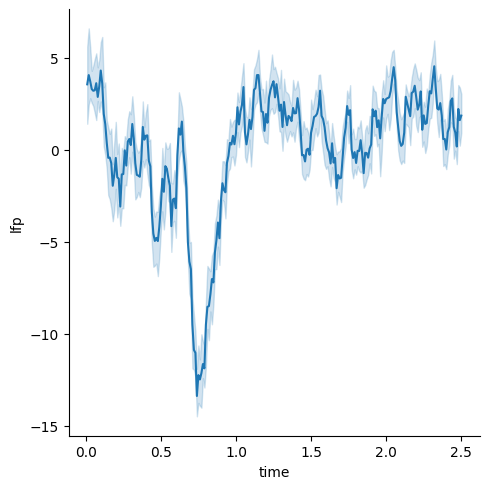

In [14]:
df = dset[['lfp']].to_dataframe().reset_index()
mask = df['trial'] < 50
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

Make a line plot of `time` vs `lfp`, but only for for trials where `contrast_left` was `100`

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


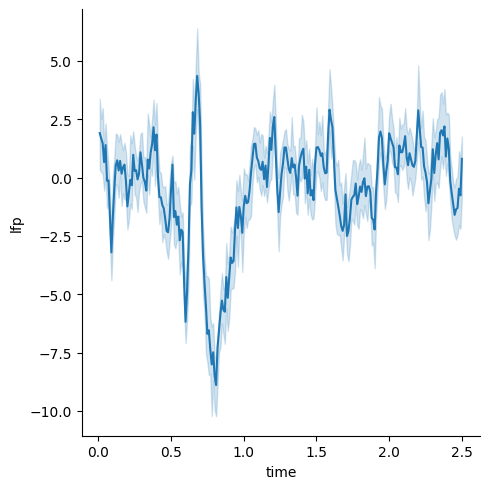

In [19]:
df = dset[['lfp', 'contrast_left']].to_dataframe().reset_index()
mask = df['contrast_left'] == 100
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

There seems to be a strong response right after t=0.5.  This is when the visual stimulus appeared in each trial.  Let's see if the response is still there when no stimulus was presented: 

Make a line plot of `time` vs `lfp`, but only for for trials where `contrast_left` was `0` and `contrast_right` was `0`

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


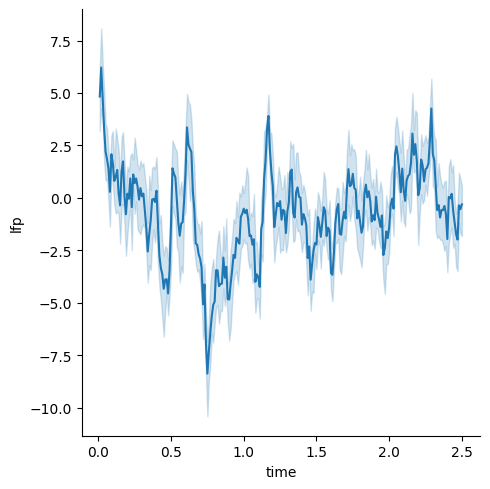

In [20]:
df = dset[['lfp', 'contrast_left', 'contrast_right']].to_dataframe().reset_index()
mask1 = df['contrast_left'] == 0
mask2 = df['contrast_right'] == 0
mask = mask1 & mask2
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

Make a line plot of `time` vs `lfp`, but only for for trials where either `contrast_left` was greator `50` **or** `contrast_right` was greater than `50`

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


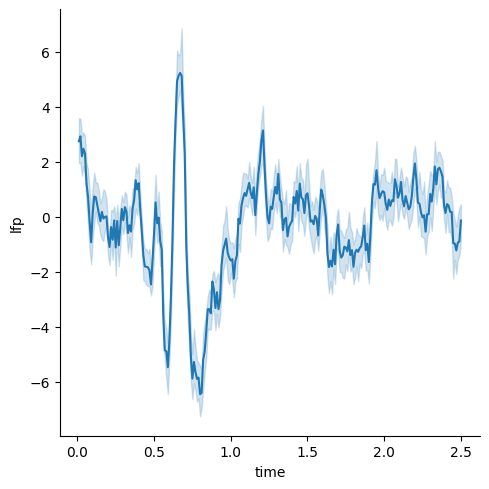

In [22]:
df = dset[['lfp', 'contrast_left', 'contrast_right']].to_dataframe().reset_index()
mask1 = df['contrast_left'] > 50
mask2 = df['contrast_right'] > 50
mask = mask1 | mask2
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

Make a line plot of `time` vs `lfp`, but only for `brain_area_lfp` measurements in the visual cortex area `'VISp'`.

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


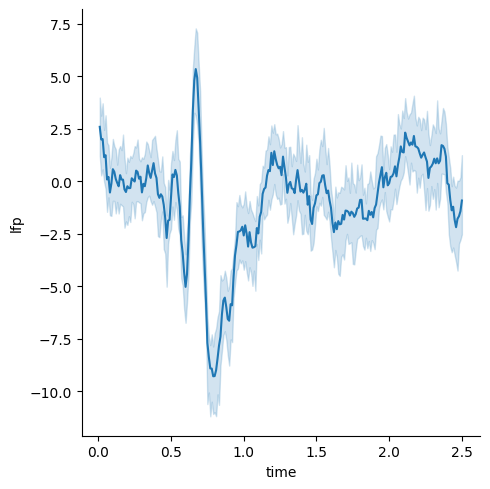

In [23]:
df = dset[['lfp', 'brain_area_lfp']].to_dataframe().reset_index()
mask = df['brain_area_lfp'] == 'VISp'
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

Does the hippocampus have such a distinct response?  Make a line plot of `time` vs `lfp`, but only for `brain_area_lfp` measurements in either `'DG'` or `'CA3'`.

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


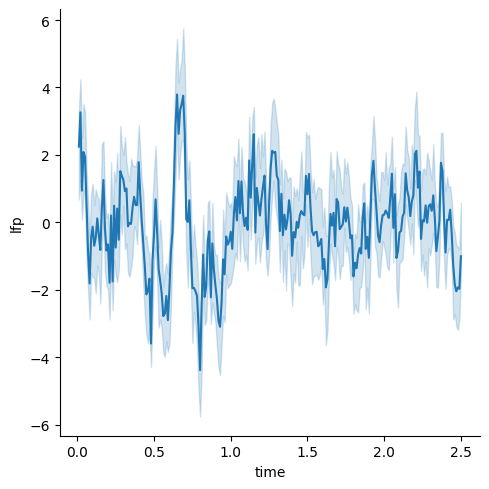

In [25]:
df = dset[['lfp', 'brain_area_lfp']].to_dataframe().reset_index()
mask1 = df['brain_area_lfp'] == 'DG'
mask2 = df['brain_area_lfp'] == 'CA3'
mask = mask1 | mask2
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

How does the mouse's response affect the lfp in the visual cortex?  Make a line plot of `time` vs `lfp`, but only for `brain_area_lfp` measurements in the visual cortex area `'VISp'`, and use `hue` to compare the lfp between different `response_type` values.

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


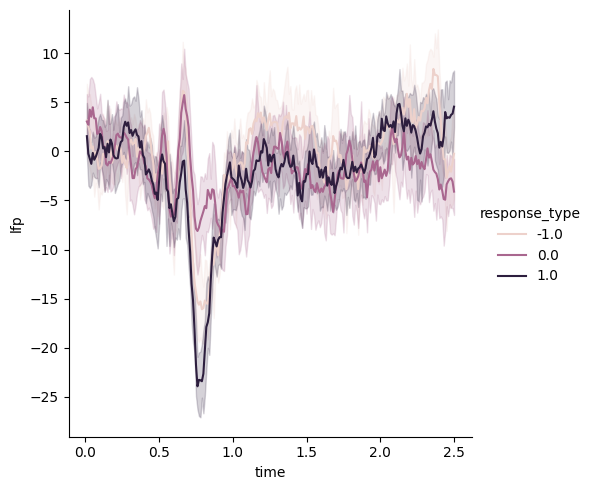

In [32]:
df = dset[['lfp', 'brain_area_lfp', 'response_type']].to_dataframe().reset_index()
mask = df['brain_area_lfp'] == 'VISp'
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', hue='response_type', n_boot=20);

There are so many different brain areas; let's plot them all at once in different subplots.  Make a line plot of `time` vs `lfp`, where `col` is the brain area.  (if there are too many columns, you can set `col_wrap=3` to make new rows automatically).

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


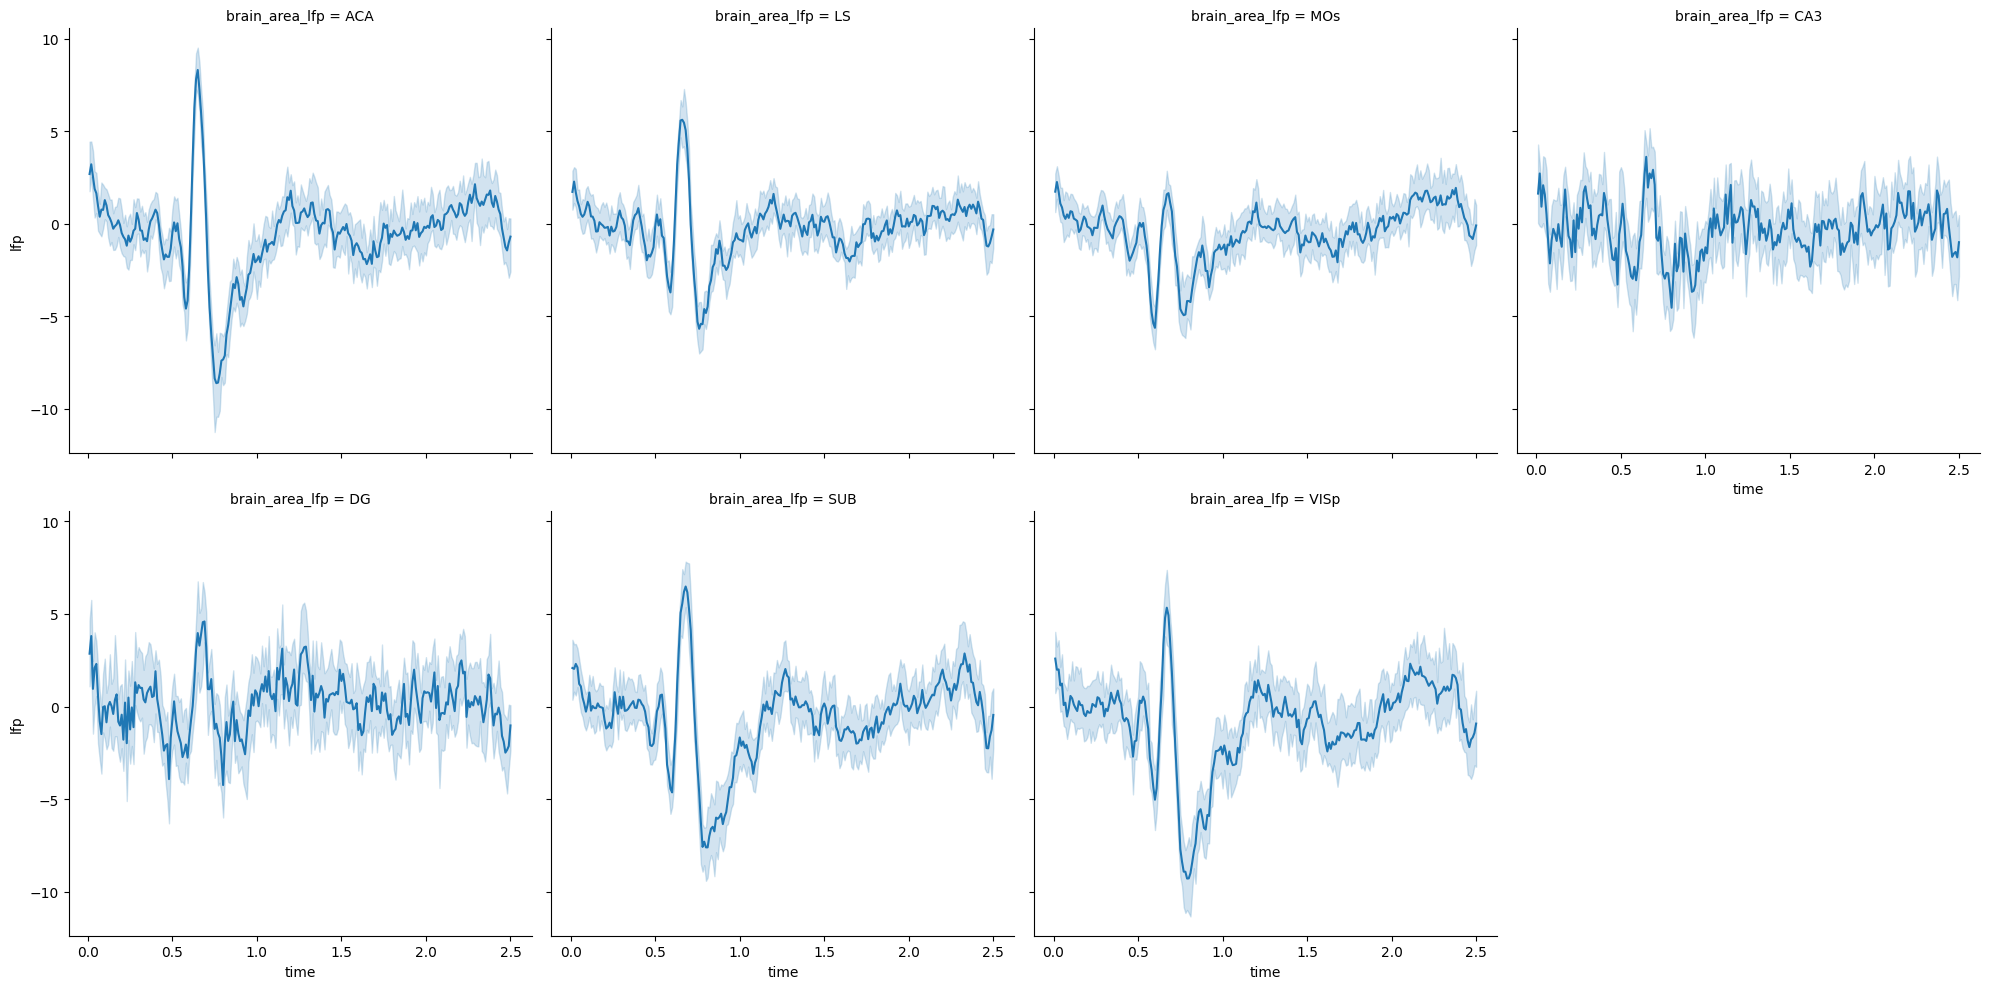

In [36]:
df = dset[['lfp', 'brain_area_lfp']].to_dataframe().reset_index()
sns.relplot(data=df, x='time', y='lfp', kind='line', col='brain_area_lfp', col_wrap=4, n_boot=20);

For each brain area, compare the lfps to different response types.  Which brain areas seem most related to the subject's behavior?

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


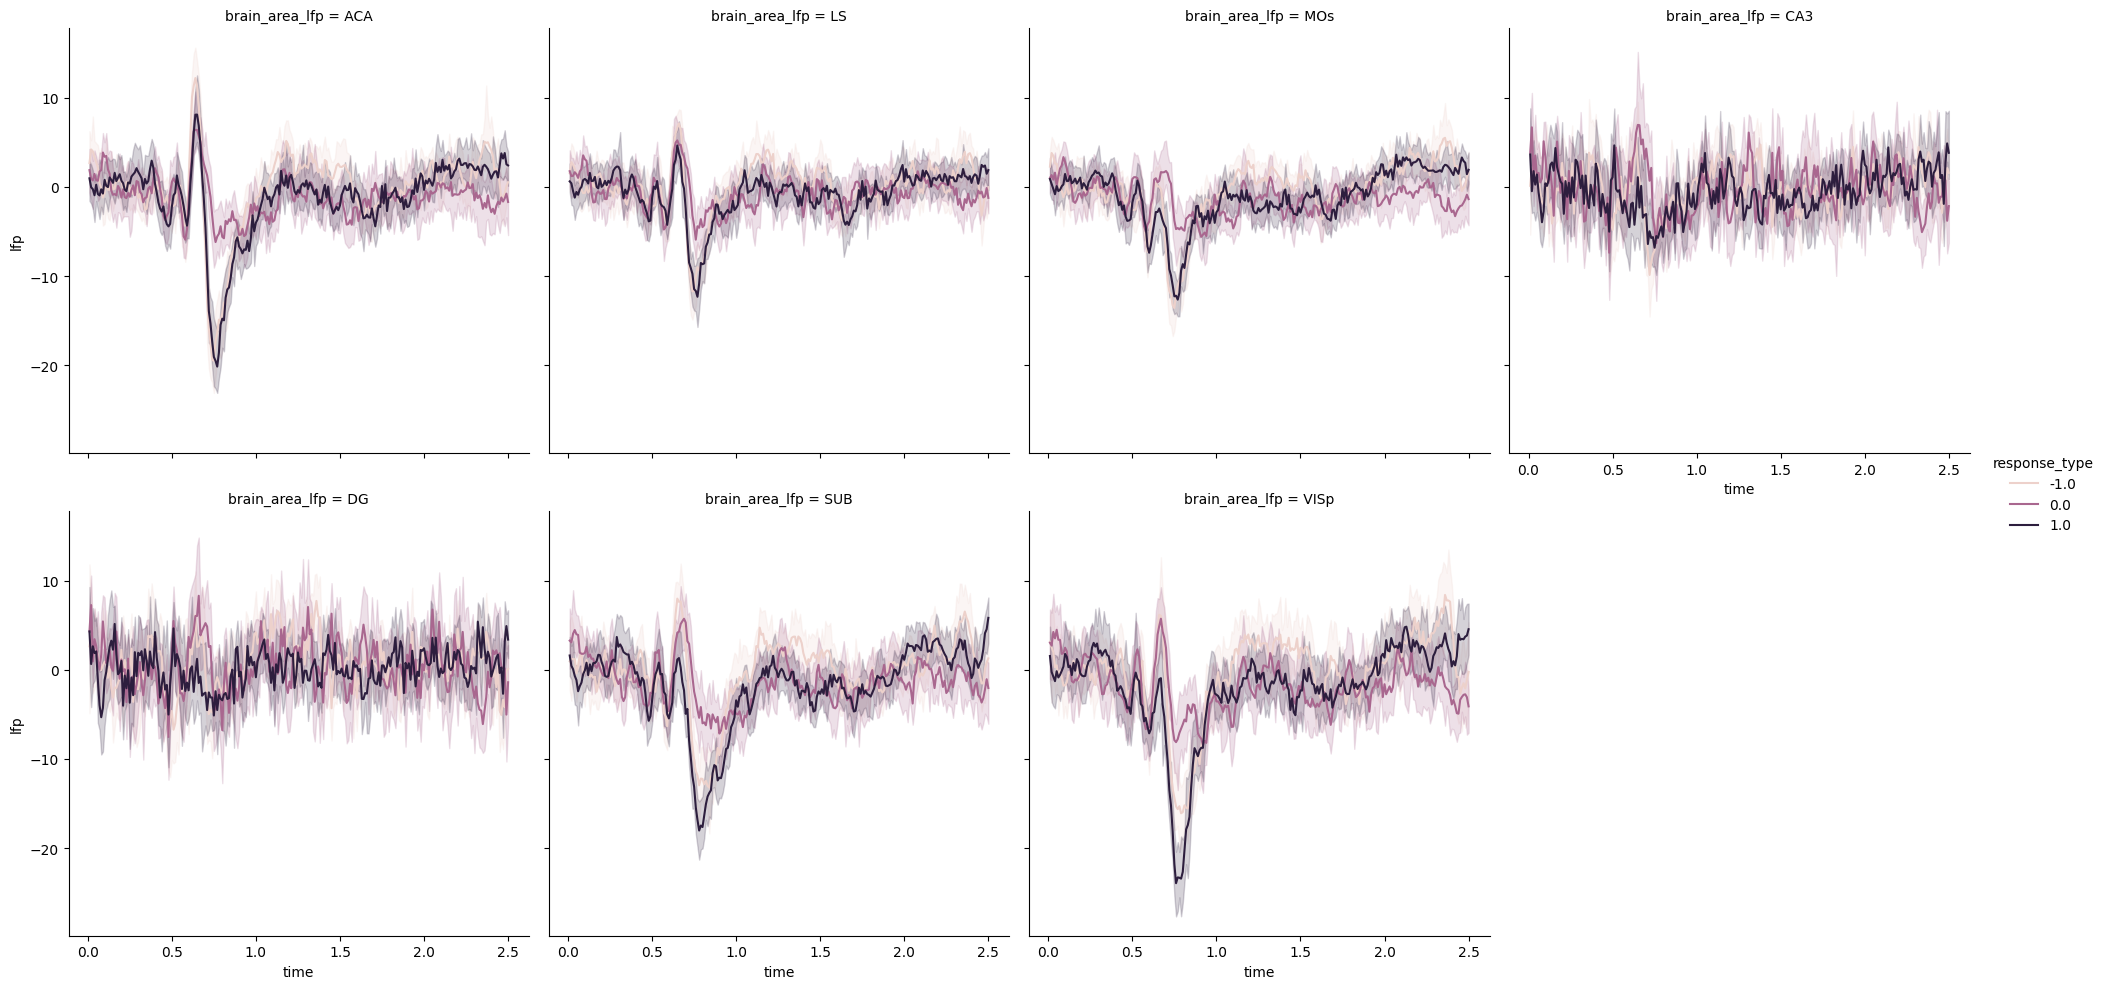

In [35]:
df = dset[['lfp', 'brain_area_lfp', 'response_type']].to_dataframe().reset_index()
sns.relplot(data=df, x='time', y='lfp', kind='line', col='brain_area_lfp', hue='response_type', col_wrap=4, n_boot=20);

## Visualizing Average LFP Data with Heatmap

Let's try to visualize same information for all brain area in a different format. Sometimes, it might be enough to only see variations in terms of color change rather than number. This case, heatmap could be very informative to identify patterns in the time series of mean LFP signal across all trials.

We will make use of group-by method of Pandas dataframe to aggregate LFP and Seaborn heatmap method to visualize

`sns.heatmap()`: Create a heatmap visualization to display the mean LFP data using a color gradient. </br>
`df.groupby()`: Aggregate colums with respect to a categorical valued column. </br>
`df.unstack()`: Convert multi-index dataframe to wide format table. </br>

**Example** Find mean lfp of each brain_area 

In [38]:
lfp.groupby('brain_area_lfp')['lfp'].mean()

brain_area_lfp
ACA    -0.514545
CA3    -0.330150
DG      0.186883
LS     -0.244636
MOs    -0.440104
SUB    -0.595160
VISp   -0.885078
Name: lfp, dtype: float64

Find mean lfp of each time

In [39]:
lfp.groupby('time')['lfp'].mean()

time
0.01    2.185657
0.02    2.613272
0.03    1.737390
0.04    1.663617
0.05    1.403416
          ...   
2.46   -1.527758
2.47   -1.618838
2.48   -1.494268
2.49   -1.259201
2.50   -0.640280
Name: lfp, Length: 250, dtype: float64

There are other aggregation methods too like median(), std() for standard deviation, min() for minimum, max() for maximum, etc

Find median LFP of each brain area

In [40]:
lfp.groupby('brain_area_lfp').median()

,trial,time,lfp
brain_area_lfp,,,
ACA,182.5,1.255,-0.479932
CA3,182.5,1.255,-0.426170
DG,182.5,1.255,0.299241
LS,182.5,1.255,-0.173639
MOs,182.5,1.255,-0.463571
SUB,182.5,1.255,-0.636395
VISp,182.5,1.255,-1.085343


Find minimum lfp of each brain_area

In [41]:
lfp.groupby('brain_area_lfp')['lfp'].min()

brain_area_lfp
ACA    -122.177778
CA3    -130.074430
DG     -172.058377
LS      -84.084014
MOs    -100.964490
SUB    -114.875510
VISp   -133.851206
Name: lfp, dtype: float64

Find maximum lfp of each brain_area

In [42]:
lfp.groupby('brain_area_lfp')['lfp'].max()

brain_area_lfp
ACA     143.055556
CA3     140.405762
DG      173.035358
LS       86.690986
MOs     126.365510
SUB     152.306463
VISp    108.156215
Name: lfp, dtype: float64

Find standard deviation of LFP in each brain area

In [43]:
lfp.groupby('brain_area_lfp')['lfp'].std()

brain_area_lfp
ACA     14.644016
CA3     19.595801
DG      21.019145
LS      11.689013
MOs     12.413976
SUB     15.402966
VISp    17.691439
Name: lfp, dtype: float64

**Example** Let's find mean lfp value of each trial of each brain area

In [44]:
lfp.groupby(['brain_area_lfp', 'trial'])['lfp'].mean()

brain_area_lfp  trial
ACA             1         0.677562
                2        -1.527103
                3        -4.225222
                4        -6.515680
                5         0.106590
                           ...    
VISp            360      -1.776045
                361      11.029212
                362      -2.597403
                363      -1.453761
                364      -0.708299
Name: lfp, Length: 2548, dtype: float64

Find mean lfp value of each time bin of each brain area

In [45]:
lfp.groupby(['brain_area_lfp', 'time'])['lfp'].mean()

brain_area_lfp  time
ACA             0.01    2.685471
                0.02    3.209860
                0.03    2.529335
                0.04    1.884860
                0.05    1.645758
                          ...   
VISp            2.46   -2.188754
                2.47   -1.785507
                2.48   -1.664128
                2.49   -1.426965
                2.50   -0.917550
Name: lfp, Length: 1750, dtype: float64

We can convert this table to a wide format using `.unstack()` method. Can we try that?

In [46]:
lfp.groupby(['brain_area_lfp', 'time'])['lfp'].mean().unstack()

time,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50
brain_area_lfp,,,,,,,,,,,,,,,,,,,,,
ACA,2.685471,3.209860,2.529335,1.884860,1.645758,0.967400,0.379396,0.767064,0.746887,1.277259,...,1.500397,1.202992,0.766545,0.520117,-0.258943,-0.766727,-1.254212,-1.441269,-1.015720,-0.695543
CA3,1.629518,2.715249,0.921293,2.078533,1.577401,0.502660,-0.979725,-2.140682,-0.898762,-0.274732,...,0.523830,0.558090,0.804373,-0.148924,-0.979483,-1.787499,-1.612644,-1.523681,-1.815537,-0.997259
DG,2.856145,3.810049,0.956899,2.094294,2.304235,0.560752,-0.789523,-1.486271,-0.024381,0.018169,...,-0.381524,-0.424394,-0.055719,-0.466114,-1.583032,-1.889798,-2.485345,-2.341369,-2.132770,-1.018312
LS,1.720520,2.275740,1.694925,1.233181,0.944536,0.527159,0.375900,0.496161,0.811752,1.184257,...,1.192567,0.850740,0.275717,0.209463,-0.530762,-1.182547,-1.228083,-1.042186,-0.693559,-0.309539
MOs,1.733737,2.255798,1.747858,1.093847,0.884589,0.458545,0.264287,0.504369,0.316759,0.677858,...,1.070688,0.696952,0.319012,0.146512,-0.086345,-0.637883,-0.711565,-0.824916,-0.466098,-0.092499
SUB,2.083217,2.036742,2.304416,2.115268,1.226303,1.093702,0.492191,0.151257,-0.273056,0.103867,...,0.069480,0.792099,0.296312,-0.383038,-1.296088,-2.241097,-2.254512,-1.622324,-1.263761,-0.451261
VISp,2.590992,1.989468,2.007001,1.145337,1.241092,0.083449,0.207126,-0.535956,-0.108534,0.574958,...,-0.163704,-0.883659,-1.384658,-1.213079,-1.829013,-2.188754,-1.785507,-1.664128,-1.426965,-0.917550


Amazing! Put this result in a dataframe

In [47]:
group = lfp.groupby(['brain_area_lfp', 'time'])['lfp'].mean().unstack()
group

time,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50
brain_area_lfp,,,,,,,,,,,,,,,,,,,,,
ACA,2.685471,3.209860,2.529335,1.884860,1.645758,0.967400,0.379396,0.767064,0.746887,1.277259,...,1.500397,1.202992,0.766545,0.520117,-0.258943,-0.766727,-1.254212,-1.441269,-1.015720,-0.695543
CA3,1.629518,2.715249,0.921293,2.078533,1.577401,0.502660,-0.979725,-2.140682,-0.898762,-0.274732,...,0.523830,0.558090,0.804373,-0.148924,-0.979483,-1.787499,-1.612644,-1.523681,-1.815537,-0.997259
DG,2.856145,3.810049,0.956899,2.094294,2.304235,0.560752,-0.789523,-1.486271,-0.024381,0.018169,...,-0.381524,-0.424394,-0.055719,-0.466114,-1.583032,-1.889798,-2.485345,-2.341369,-2.132770,-1.018312
LS,1.720520,2.275740,1.694925,1.233181,0.944536,0.527159,0.375900,0.496161,0.811752,1.184257,...,1.192567,0.850740,0.275717,0.209463,-0.530762,-1.182547,-1.228083,-1.042186,-0.693559,-0.309539
MOs,1.733737,2.255798,1.747858,1.093847,0.884589,0.458545,0.264287,0.504369,0.316759,0.677858,...,1.070688,0.696952,0.319012,0.146512,-0.086345,-0.637883,-0.711565,-0.824916,-0.466098,-0.092499
SUB,2.083217,2.036742,2.304416,2.115268,1.226303,1.093702,0.492191,0.151257,-0.273056,0.103867,...,0.069480,0.792099,0.296312,-0.383038,-1.296088,-2.241097,-2.254512,-1.622324,-1.263761,-0.451261
VISp,2.590992,1.989468,2.007001,1.145337,1.241092,0.083449,0.207126,-0.535956,-0.108534,0.574958,...,-0.163704,-0.883659,-1.384658,-1.213079,-1.829013,-2.188754,-1.785507,-1.664128,-1.426965,-0.917550


Visualize this using heatmap with the help of below code

sns.heatmap(name_of_the_grouped_dataframe)

<Axes: xlabel='time', ylabel='brain_area_lfp'>

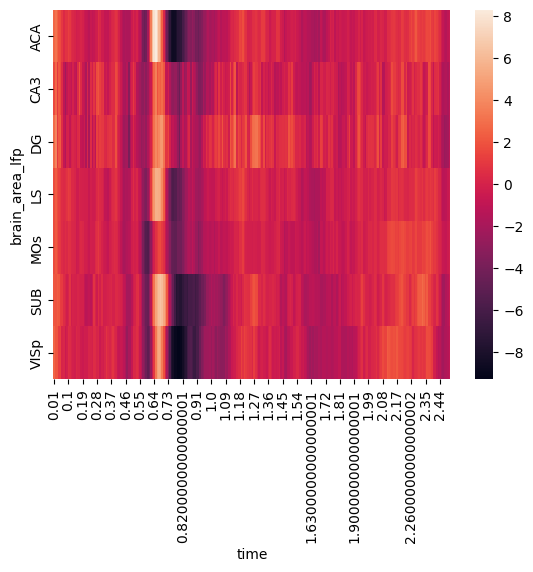

In [48]:
sns.heatmap(group)

We can select color map by specifying 'cmap'. There are many color maps to choose from like

'viridis'

'inferno'

'Greys'
 
etc


Plot a heatmap and set cmap='viridis'

<Axes: xlabel='time', ylabel='brain_area_lfp'>

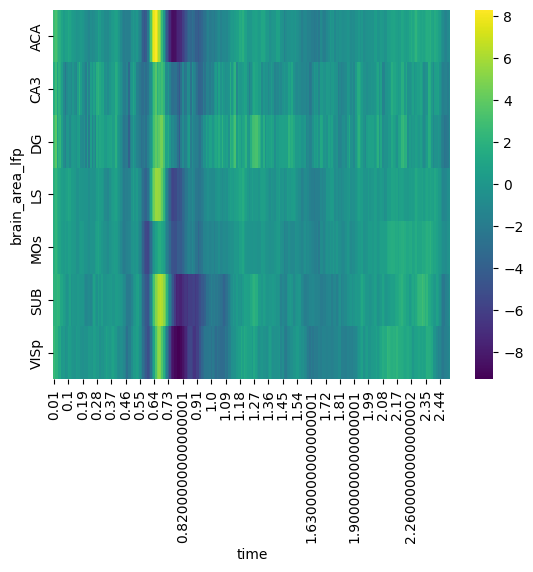

In [49]:
sns.heatmap(group, cmap='viridis')

We can set minimum and maximum values to anchor the colormap using vmin and vmax 

Set vmin=-6 and vmax=6

<Axes: xlabel='time', ylabel='brain_area_lfp'>

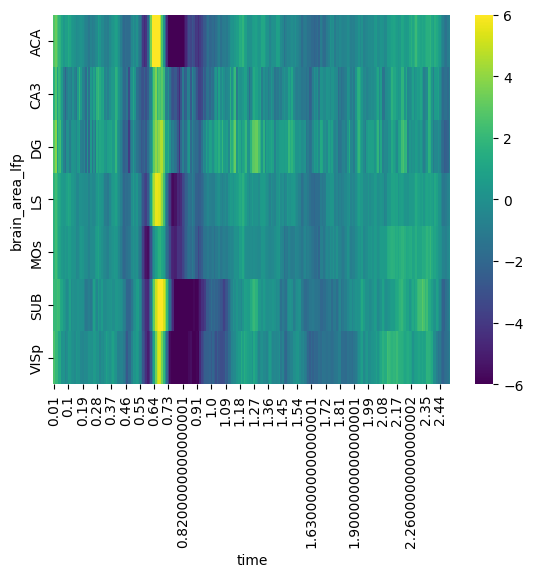

In [50]:
sns.heatmap(group, cmap='viridis', vmin=-6, vmax=6)

**Example** try plotting medians?

<Axes: xlabel='time', ylabel='brain_area_lfp'>

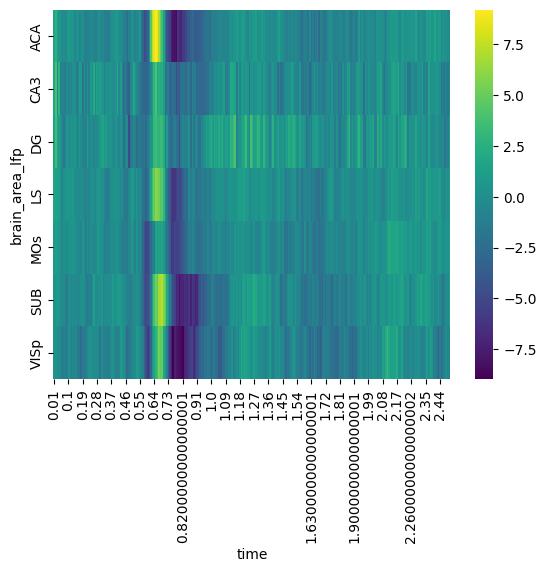

In [51]:
group = lfp.groupby(['brain_area_lfp', 'time'])['lfp'].median().unstack()
sns.heatmap(group, cmap='viridis')

Try plotting minimum LFP values? 

<Axes: xlabel='time', ylabel='brain_area_lfp'>

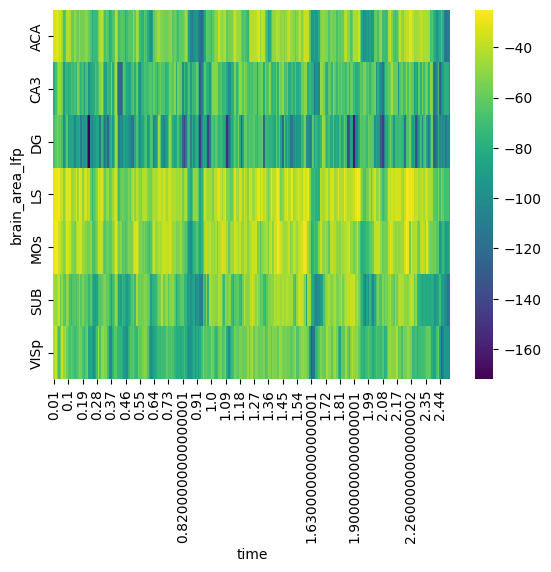

In [52]:
group = lfp.groupby(['brain_area_lfp', 'time'])['lfp'].min().unstack()
sns.heatmap(group, cmap='viridis')

Try plotting maximum LFP values? 

<Axes: xlabel='time', ylabel='brain_area_lfp'>

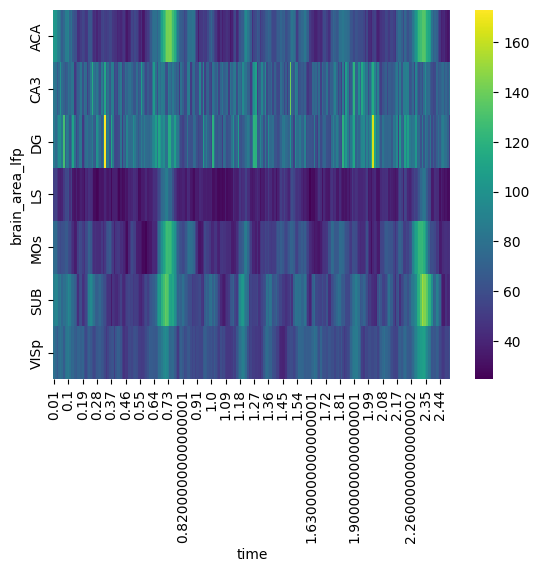

In [53]:
group = lfp.groupby(['brain_area_lfp', 'time'])['lfp'].max().unstack()
sns.heatmap(group, cmap='viridis')